### MAT3110/MAT4110, Autumn 2024, Compulsory assignment 1

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

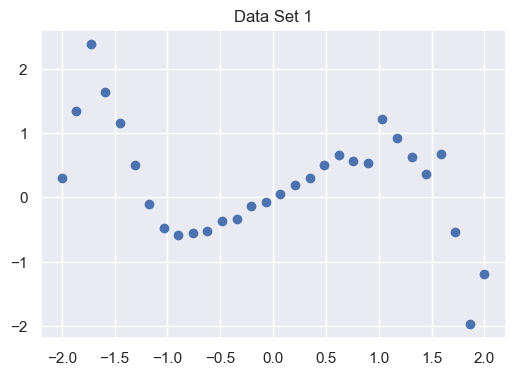

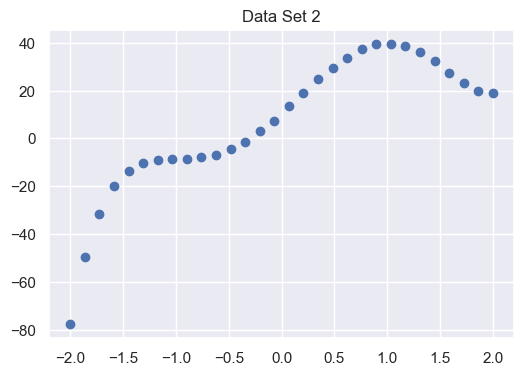

In [2]:
sns.set_theme()

# Generate data set from exercsie (which includes noise)
n = 30
start = -2
stop = 2
eps = 1
np.random.seed(1) # set seed for number gen
x = np.linspace(start, stop, n)
r = np.random.rand(n) * eps # random noise which is added to both signals

# First dataset
y1 = x*(np.cos(r + 0.5*x**3) + np.sin(0.5*x**3))
#y1_noiseless = x*(np.cos(0.5*x**3) + np.sin(0.5*x**3))

# Second dataset
y2 = 4*x**5 - 5*x**4 - 20*x**3 + 10*x**2 + 40*x + 10 + r
#y2_noiseless = 4*x**5 - 5*x**4 - 20*x**3 + 10*x**2 + 40*x + 10 


# Plot data sets
plt.figure(figsize=(6,4))
plt.plot(x, y1, 'o')
plt.title('Data Set 1')
plt.show()

plt.figure(figsize=(6,4))
plt.plot(x, y2, 'o')
plt.title('Data Set 2')
plt.show()

We want to do least squares polynomial fitting with two methods with the use of the Vandermonde matrix. 
https://en.wikipedia.org/wiki/Vandermonde_matrix

We want to find x which minimizes the 2-norm squared of Ax-b. One through QR factorization of A and the other through normal equations.


#### Method 1:
We want to use QR decomposition to solve Ax= QR x = b
Multiply Q_T on left side, Q is orthogonal so Q_T Q = I
Find x by using backsub on R*x = Q_T*b, as R is upper-triangular 

Start with implementing making a vandermonde matrix, backsub and a solver for QR wher me make use of numpys QR function.


In [3]:
# Vander matrix

def make_vander(x, n):
    '''
    x: vector input, 1d array
    n: number of column in the the output, power of x minus 1. (m = 3 -> max power = x**2)
    
    Set increasing true such that power increases to the right, matches task
    '''
    return np.vander(x, n, increasing=True)

#x = np.array([2, 4, 10])
#print(make_vander(x, 3))

#Use back sub from weekly exercises
def back_substitution(A, b):
    '''
    A: Square upper triangular matrix (n x n)
    b: 1d vector (n), 

    Solves the system by starting from the last row of the matrix (the simplest equation) 
    and working upwards to solve for each unknown
    '''
    n = np.shape(A)[0]
    x = np.zeros(n)

    for i in range(n-1, -1, -1):
        temp_sum = 0
        for j in range(i + 1, n):
            temp_sum += A[i, j] * x[j]
        x[i] = (b[i] - temp_sum) / A[i, i]
    return x


def QR_solve(A, b):
    ''' 
    A: Matrix (n x m) 
    b: vector (n), right side of the equation system

    Decomposition with QR from numpy, then use backsub to find solutions x
    The solution is found by solving the system Rx = Q_T b using back substitution. 
    Which is like Ax = b where A is upper triangular matrix.
    '''
    Q, R = np.linalg.qr(A) # returns orthogonal matrix Q and upper triangular matrix R
    b_ = np.dot(Q.T, b)
    x = back_substitution(R, b_)
    return x



#### Method 2: 
Solve normal equations using Cholesky factorization: A = L D L_T , where L is lower triangular matrix and D is a diagonal matrix. Then basically we solve for 2 equations: Lz=y and L_T*x=z with forward and back sub respectivly.

Sine A isnt symmetric we let:
1. B = A_T@A -> B*x = A_T*b = y
2. Apply cholesky to B which is symmetric: B = L*D*L_T , 
3. Set R = L_T, to match exercise
3. Seperate into L * (D*L_T) * x = L*z = y and do forward sub to find z = (D@L_t) x = (D@R) x
4. Then we do back sub to find x from equation for z.

 Implement the Cholesky factorization and forward substitution functions from the group sessions
 The solution of the normal equations is likely to be unstable. Therefore this
 method is not recommended in general. For small problems it is usually safe to use
 https://www.math.iit.edu/~fass/477577_Chapter_5.pdf

Also included MSE to calculate the different between predicted y_values and actual y_values. 

In [4]:
def cholesky(A):
    n = np.shape(A)[0]
    if n != np.shape(A)[1]:
        raise Exception("Matrix is not square")
    
    if not np.all(np.abs(A - A.T) < 1e-10):
        raise Exception("Matrix is not symmetric")

    L, D = np.zeros((n, n)), np.zeros((n, n))

    A_k = A
    for k in range(0, n):
        if np.abs(A_k[k, k]) <= 1e-10:
            raise Exception("Matrix is singular")
        
        L[:, k] = A_k[:, k] / A_k[k, k]
        D[k, k] = A_k[k, k]
        A_k = A_k - D[k, k] * (L[:, k : k + 1] @ L[:, k : k + 1].T)

    return L, D

def chol_solve(A, b):
    '''
    A: matrix (n, m)
    b: vector (n), which is the targets you want to estimate
    returns: solution for x which minimizes the least squares solution

    Solve the linear equation system where Ax = b then multiply A_T left side.
    B = A_T@A -> B*x = A_T*b = y
    Apply cholesky to B which is symmetric: B = L*D*L_T
    Seperate into L * (D*L_T) * x = L*z = y and do forward sub to find z = D L_t x = D R x
    Then we do back sub to find x from equation for z.
    '''
    B = A.T @ A #make a symmetric matrix
    y = A.T @ b # R.T * z = y

    cond = np.linalg.cond(B)  

    # print condition number if large
    if(cond > 1e5):
        print(f'Warning: Condition number for matrix B might give bad results, condition number = {cond:.0f}')

    L, D = cholesky(B)
    #L1 = np.linalg.cholesky(B) #tested if correctly found L
  
    R = L.T #rename to R, as L.T

    # Solve for z in, R.T * z = y. (lower tri -> forward sub), where z =  D R x
    z = forward_substitution(R.T, y)

    #Then solve for x in, D R * x = z
    x = back_substitution(D@R, z)
    
    return x


def forward_substitution(A, b):
    '''
    L : A lower triangular matrix of shape (n, n)
    b : 1D array (n), right hand side of system Lx=b
    returns x: (n), solution vector

    Similar to backward_substitution, however loop starts at 0 as we iterate downwards
    in the matrix and solve the lower triangular system, A x = b.
    '''
    n = np.shape(A)[0]
    x = np.zeros(n)

    for i in range(n):
        temp_sum = 0
        for j in range(i):
            temp_sum += A[i, j] * x[j]
        x[i] = (b[i] - temp_sum) / A[i, i]

    return x

def mse(y_true, y_pred):
    """Calculate mean squared error to evaluate how well our least squares did."""
    return np.mean((y_true - y_pred) ** 2)

First create the Vandermonde matrices (with m= 3 and m=8) and uses the existing funtions to solve using both QR and Cholesky.
Then plot the results together in a 2x2 grid. 

In [5]:
# Solve with QR
# m - columns
m1 = 3 # 2nd degree poly
m2 = 8 # 7th degree poly

# Vandermonde with dataset
A_1 = make_vander(x, m1)
A_2 = make_vander(x, m2) 

# Solve with first dataset (y1) using Cholesky fac
x1_chol_3 = chol_solve(A_1, y1)
y1_pred_chol_3 = np.dot(A_1, x1_chol_3)

x1_chol_8 = chol_solve(A_2, y1)
y1_pred_chol_8 = np.dot(A_2, x1_chol_8)

#  Second dataset (y2) 
x2_chol_3 = chol_solve(A_1, y2)
y2_pred_chol_3 = np.dot(A_1, x2_chol_3)

x2_chol_8 = chol_solve(A_2, y2)
y2_pred_chol_8 = np.dot(A_2, x2_chol_8)


# Fit the first dataset (y1)
x1_QR_3 = QR_solve(A_1, y1)
y1_pred_QR_3 = np.dot(A_1, x1_QR_3)

x1_QR_8 = QR_solve(A_2, y1)
y1_pred_QR_8 = np.dot(A_2, x1_QR_8)

# Fit the second dataset (y2)
x2_QR_3 = QR_solve(A_1, y2)
y2_pred_QR_3 = np.dot(A_1, x2_QR_3)

x2_QR_8 = QR_solve(A_2, y2)
y2_pred_QR_8 = np.dot(A_2, x2_QR_8)

# MSE for different methods
#Set 1
mse_QR_3 = mse(y1, y1_pred_QR_3)
mse_chol_3 = mse(y1, y1_pred_chol_3)
mse_QR_8 = mse(y1, y1_pred_QR_8)
mse_chol_8 = mse(y1, y1_pred_chol_8)

mse_QR_3 = mse(y2, y2_pred_QR_3)
mse_chol_3 = mse(y2, y2_pred_chol_3)
mse_QR_8 = mse(y2, y2_pred_QR_8)
mse_chol_8 = mse(y2, y2_pred_chol_8)

#MSE metric but didnt notice any difference between them
print(f"Dataset 1, m=3, MSE: QR = {mse_QR_3:.2e}, Chol = {mse_chol_3:.2e}")
print(f"Dataset 1, m=8, MSE: QR = {mse_QR_8:.2e}, Chol = {mse_chol_8:.2e}")

print(f"Dataset 2, m=3, MSE: QR = {mse_QR_3:.2e}, Chol = {mse_chol_3:.2e}")
print(f"Dataset 2, m=8, MSE: QR = {mse_QR_8:.2e}, Chol = {mse_chol_8:.2e}")



Dataset 1, m=3, MSE: QR = 8.05e+01, Chol = 8.05e+01
Dataset 1, m=8, MSE: QR = 5.01e-02, Chol = 5.01e-02
Dataset 2, m=3, MSE: QR = 8.05e+01, Chol = 8.05e+01
Dataset 2, m=8, MSE: QR = 5.01e-02, Chol = 5.01e-02


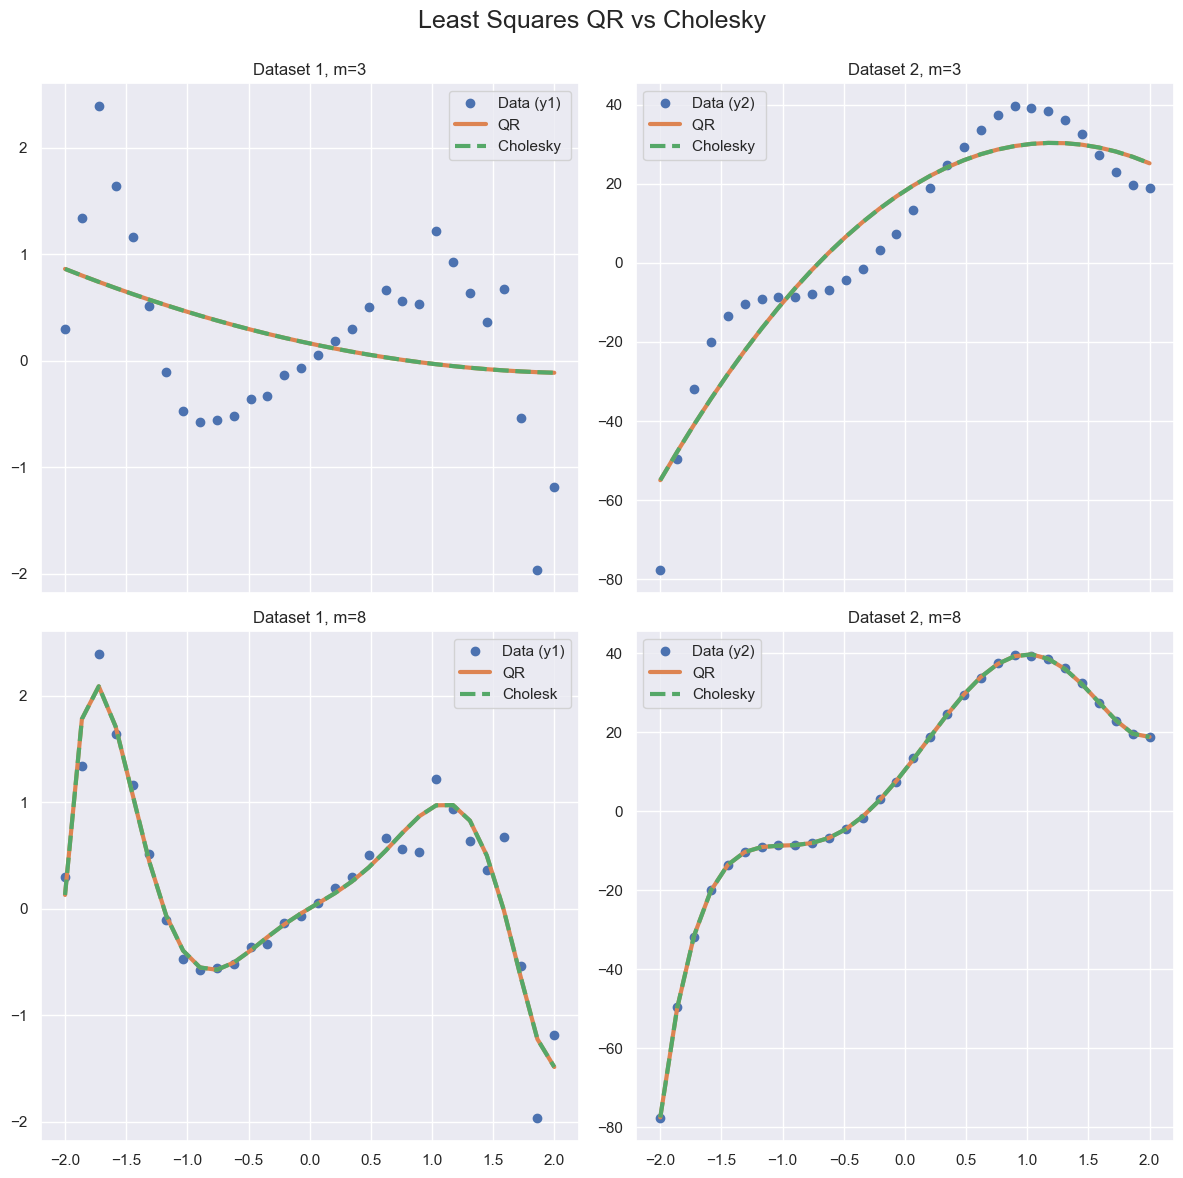

<Figure size 640x480 with 0 Axes>

In [6]:
# Plot for both methods and datasets with m=3 and m=8
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(12, 12))
ax0, ax1, ax2, ax3 = axs.flatten()
sns.set_theme()
fig.suptitle('Least Squares QR vs Cholesky', fontsize=18)

# Dataset 1
ax0.plot(x, y1, 'o', label='Data (y1)')
ax0.plot(x, y1_pred_QR_3, '-', linewidth=3, label='QR')
ax0.plot(x, y1_pred_chol_3, '--', linewidth=3, label='Cholesky ')
ax0.set_title('Dataset 1, m=3')
ax0.legend()

ax2.plot(x, y1, 'o', label='Data (y1)')
ax2.plot(x, y1_pred_QR_8, '-', linewidth=3, label='QR')
ax2.plot(x, y1_pred_chol_8, '--', linewidth=3, label='Cholesk')
ax2.set_title('Dataset 1, m=8')
ax2.legend()

# Dataset 2
ax1.plot(x, y2, 'o', label='Data (y2)')
ax1.plot(x, y2_pred_QR_3, '-', linewidth=3, label='QR ')
ax1.plot(x, y2_pred_chol_3, '--', linewidth=3, label='Cholesky ')
ax1.set_title('Dataset 2, m=3')
ax1.legend()

ax3.plot(x, y2, 'o', label='Data (y2)')
ax3.plot(x, y2_pred_QR_8, '-', linewidth=3, label='QR')
ax3.plot(x, y2_pred_chol_8, '--', linewidth=3, label='Cholesky')
ax3.set_title('Dataset 2, m=8')
ax3.legend()

plt.tight_layout(rect=[0, 0, 1, 0.985])
#plt.savefig("QR_vs_Cholesky.pdf")
plt.show()
plt.clf()




As the plot show they overlap excatly which we can also observe by calculating the MSE for both which is seemingly identical. I also printed the condition number of the matrix B = A_T A when m=8 as it exceeds an arbitrary value of 1e5 which i deemed to be quite high, however i didnt notice any worse fit due to this. As we multiply our matrix A with A_T in cholesky i'd expect when the condition number is high we would see a worse fit, but that didnt really show up in the results. Perhaps by increasing m to 50-100 we might see some real issues occur for Cholesky solution. The fact that by increasing m we increase the complexity of the fit on our data, it might perhaps outweigh the errors which exist due to the condition number.
